## Import libraries, read in data and see what data looks like

In [32]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Data science
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

# Geospatial
import contextily as cx
import xarray as xr
import zarr # Not referenced, but required for xarray

# Import Planetary Computer tools
import fsspec
import pystac

# Other
import os
import zipfile
from itertools import cycle

In [62]:
df = pd.read_csv("6_primaries.csv")

In [63]:
df = df.drop(['country','continent','stateProvince'], 1)

In [30]:
# CS is all absence data, LF is all presence data, each has 2790 observations
df[df['species'] =='Crinia Signifera'].groupby(by='occurrenceStatus').count()
df[df['species'] =='Litoria Fallax'].groupby(by='occurrenceStatus').count()

,Unnamed: 0,gbifID,eventDate,decimalLatitude,decimalLongitude,species,key,ppt_mean,srad_mean,tmax_mean,tmin_mean,vap_mean,ws_mean
occurrenceStatus,,,,,,,,,,,,,
1,2790,2790,2790,2790,2790,2790,2790,2790,2790,2790,2790,2790,2790


## Explore 6 primary vars, continuous vs. categorical 
## take 1: group by

1. see the dfrequency istribution of the 6 xs
![index_demo](histogram.png)

In [67]:
#2. normalize everything
from sklearn import preprocessing
x_data = ['ppt_mean','srad_mean','tmax_mean','tmin_mean','vap_mean','ws_mean']
for xi in (x_data):
    new_name = "normalized_" + xi
    new_col = preprocessing.normalize([df[xi]]).T
    df[new_name] = new_col
df2 = df.drop(['Unnamed: 0','gbifID','eventDate','species','key','ppt_mean','srad_mean','tmax_mean','tmin_mean','vap_mean','ws_mean'],1)
df2.head()

,decimalLatitude,decimalLongitude,occurrenceStatus,normalized_ppt_mean,normalized_srad_mean,normalized_tmax_mean,normalized_tmin_mean,normalized_vap_mean,normalized_ws_mean
0,-33.466600,150.185000,0,0.013023,0.013477,0.010380,0.008058,0.010088,0.012405
1,-33.833166,151.014700,0,0.012496,0.013287,0.013917,0.014849,0.014225,0.014817
2,-33.714100,151.143000,0,0.017151,0.013311,0.013294,0.014386,0.013966,0.013461
3,-33.907400,150.833720,0,0.011218,0.013485,0.013908,0.013345,0.013509,0.012356
4,-33.759766,151.113259,0,0.014923,0.013330,0.013624,0.014854,0.014188,0.013989


In [80]:
#df2.to_csv('6_primaries_normalized.csv')

**A simple approach could be to group the continuous variable using the categorical variable, measure the variance in each group and comparing it to the overall variance of the continuous variable. If the variance after grouping falls down significantly, it means that the categorical variable can explain most of the variance of the continuous variable and so the two variables likely have a strong association.**

In [113]:
for xi in df2.columns[3:]:
    print(xi,"\n",
          "variance without grouping: ", df2[xi].var(),'\n',
          "variance after grouping by presence: ", df2[df2['occurrenceStatus']==1][xi].var(),'\n',
          "variance after grouping by absence: ", df2[df2['occurrenceStatus']==0][xi].var() ,
          "\n")

normalized_ppt_mean 
 variance without grouping:  2.79715617896237e-06 
 variance after grouping by presence:  1.9546833179597815e-06 
 variance after grouping by absence:  3.453144359575519e-06 

normalized_srad_mean 
 variance without grouping:  2.000103141834957e-08 
 variance after grouping by presence:  2.3870801872263764e-08 
 variance after grouping by absence:  1.3120190918406364e-08 

normalized_tmax_mean 
 variance without grouping:  1.0659123307446113e-06 
 variance after grouping by presence:  1.0746020237273847e-07 
 variance after grouping by absence:  1.695516455595448e-06 

normalized_tmin_mean 
 variance without grouping:  4.3463213328971876e-06 
 variance after grouping by presence:  1.5023362972960446e-06 
 variance after grouping by absence:  5.768081961039442e-06 

normalized_vap_mean 
 variance without grouping:  1.5547912471859619e-06 
 variance after grouping by presence:  4.29462824860155e-07 
 variance after grouping by absence:  2.176366355628875e-06 

normal

**Diff sum of #frogs at quartiles of x1-x6**

四等分& 五等分

In [135]:
quartile = []
for xi in df2.columns[3:]:
    q1 = df2.sort_values(by= xi)["occurrenceStatus"][0:1395].sum()
    q2 = df2.sort_values(by= xi)["occurrenceStatus"][1395:2790].sum()
    q3 = df2.sort_values(by= xi)["occurrenceStatus"][2790:4185].sum()
    q4 = df2.sort_values(by= xi)["occurrenceStatus"][4185:5580].sum()
    row = [q1,q2,q3,q4]
    quartile.append(row)
qdf = pd.DataFrame(np.asarray(quartile).T)
qdf.columns = df2.columns[3:]
qdf

,normalized_ppt_mean,normalized_srad_mean,normalized_tmax_mean,normalized_tmin_mean,normalized_vap_mean,normalized_ws_mean
0,678,1119,264,380,380,612
1,833,650,638,680,637,438
2,855,284,1137,588,631,611
3,424,737,751,1142,1142,1129


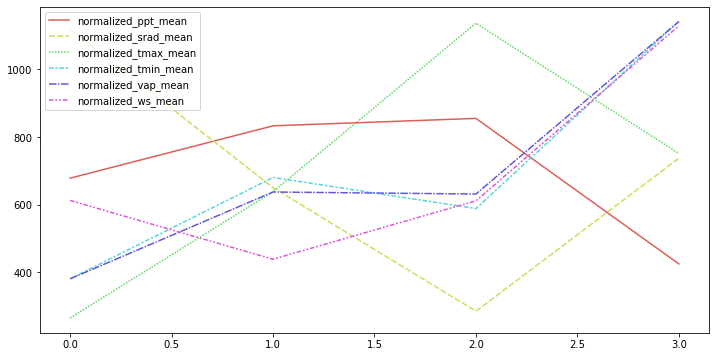

In [167]:
palette = sns.color_palette("hls", 6)
from matplotlib import rcParams
rcParams['figure.figsize'] = 12,6
plt1 = sns.lineplot(data = qdf,legend = 'full', palette = palette)
sns.move_legend(plt1,loc = 'upper left')

In [148]:
quintessential  = []
for xi in df2.columns[3:]:
    q1 = df2.sort_values(by= xi)["occurrenceStatus"][0:1116].sum()
    q2 = df2.sort_values(by= xi)["occurrenceStatus"][1116:2232].sum()
    q3 = df2.sort_values(by= xi)["occurrenceStatus"][2232:3348].sum()
    q4 = df2.sort_values(by= xi)["occurrenceStatus"][3348:4464].sum()
    q5 = df2.sort_values(by= xi)["occurrenceStatus"][4464:5580].sum()
    row = [q1,q2,q3,q4,q5]
    quintessential.append(row)
q5df = pd.DataFrame(np.asarray(quintessential).T)
q5df.columns = df2.columns[3:]
q5df

,normalized_ppt_mean,normalized_srad_mean,normalized_tmax_mean,normalized_tmin_mean,normalized_vap_mean,normalized_ws_mean
0,556,950,143,158,184,528
1,517,573,433,600,597,312
2,917,432,764,494,486,432
3,498,217,914,620,617,568
4,302,618,536,918,906,950


<AxesSubplot:>

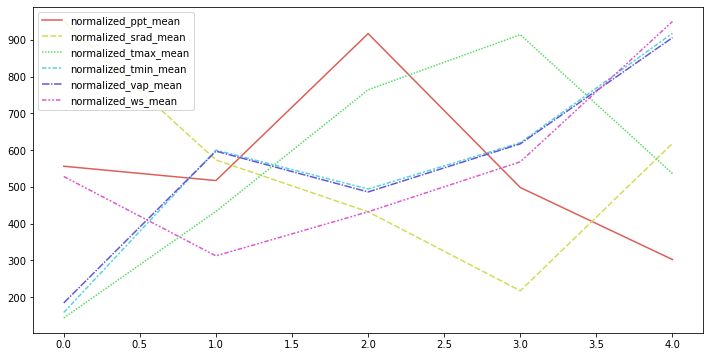

In [170]:
sns.lineplot(data = q5df,legend = 'full', palette = palette)